In [1]:
import os
data_dir = "datasets/jena_climate"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")
f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines), lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551 01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]] # Date Time 제거
    float_data[i, :] = values
    
float_data.shape

(420551, 14)

In [4]:
import matplotlib.pyplot as plt

tmp = float_data[:, 1]
plt.plot(range(len(tmp)), tmp)

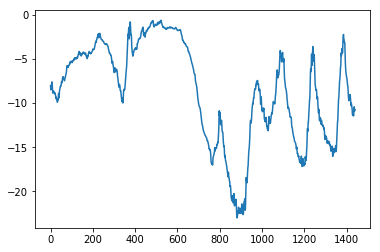

In [5]:
plt.plot(range(1440), tmp[:1440])

In [25]:
import matplotlib.pyplot as plt
def plot(history):
    epoch = range(1, len(history['mean_absolute_error']) + 1)
    plt.clf()
    plt.plot(epoch, history['mean_absolute_error'], 'bo', label='Training Mae')
    plt.plot(epoch, history['loss'], 'b', label='Training Loss')
    plt.plot(epoch, history['val_mean_absolute_error'], 'ro', label='Validation Mae')
    plt.plot(epoch, history['val_loss'], 'r', label='Validation Loss')
    plt.legend()
    plt.show()

In [7]:
mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [12]:
look_back = ((24 * 60) // 10) * 10
step = 6
delay = (24 * 60) // 10
batch_size = 128

train_gen = generator(
    float_data,
    lookback = look_back,
    delay = delay,
    min_index = 0,
    max_index = 20000,
    shuffle = True,
    step = step,
    batch_size = batch_size
)

validation_gen = generator(
    float_data,
    lookback = look_back,
    delay = delay,
    min_index = 20001,
    max_index = 30000,
    step = step,
    batch_size = batch_size
)

test_gen = generator(
    float_data,
    lookback = look_back,
    delay = delay,
    min_index = 30001,
    max_index = None,
    step = step,
    batch_size = batch_size
)

validation_step = (30000 - 20001 - look_back) // batch_size
test_step = (len(float_data) - 3000 - look_back) // batch_size

In [9]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [10]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(1))
model.save_weights('tmp.h5')

In [17]:
model.load_weights('tmp.h5')
model.compile(loss='mae', optimizer='rmsprop', metrics=['mae'])
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=validation_gen,
    validation_steps=validation_step
)

Epoch 1/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3407 - mean_absolute_error: 0.3407 - val_loss: 0.4911 - val_mean_absolute_error: 0.4911
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2714 - mean_absolute_error: 0.2714 - val_loss: 0.9692 - val_mean_absolute_error: 0.9692
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2356 - mean_absolute_error: 0.2356 - val_loss: 0.7081 - val_mean_absolute_error: 0.7081
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2156 - mean_absolute_error: 0.2156 - val_loss: 0.9149 - val_mean_absolute_error: 0.9149
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1982 - mean_absolute_error: 0.1982 - val_loss: 0.6770 - val_mean_absolute_error: 0.6770
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1851 - mean_absolute_error: 0.1851 - val_loss: 0.8858 - val_mean_absolute_error: 0.8858
Epoch 7/20

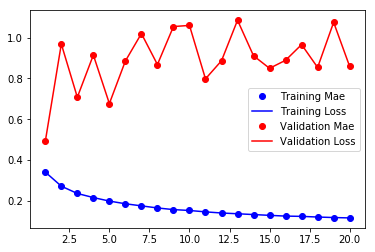

In [26]:
plot(history.history)

In [27]:
look_back = ((24 * 60) // 10) * 10
step = 3
delay = (24 * 60) // 10
batch_size = 128

train_gen = generator(
    float_data,
    lookback = look_back,
    delay = delay,
    min_index = 0,
    max_index = 20000,
    shuffle = True,
    step = step,
    batch_size = batch_size
)

validation_gen = generator(
    float_data,
    lookback = look_back,
    delay = delay,
    min_index = 20001,
    max_index = 30000,
    step = step,
    batch_size = batch_size
)

test_gen = generator(
    float_data,
    lookback = look_back,
    delay = delay,
    min_index = 30001,
    max_index = None,
    step = step,
    batch_size = batch_size
)

validation_step = (30000 - 20001 - look_back) // batch_size
test_step = (len(float_data) - 3000 - look_back) // batch_size

In [31]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))
model.save_weights('tmp.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.load_weights('tmp.h5')
model.compile(loss='mae', optimizer='rmsprop', metrics=['mae'])
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=validation_gen,
    validation_steps=validation_step
)

Epoch 1/20
500/500 [==============================] - 92s 183ms/step - loss: 0.2912 - mean_absolute_error: 0.2912 - val_loss: 0.4901 - val_mean_absolute_error: 0.4901
Epoch 2/20
500/500 [==============================] - 90s 181ms/step - loss: 0.2219 - mean_absolute_error: 0.2219 - val_loss: 0.4237 - val_mean_absolute_error: 0.4237
Epoch 3/20
500/500 [==============================] - 92s 184ms/step - loss: 0.1888 - mean_absolute_error: 0.1888 - val_loss: 0.3966 - val_mean_absolute_error: 0.3966
Epoch 4/20
500/500 [==============================] - 90s 181ms/step - loss: 0.1652 - mean_absolute_error: 0.1652 - val_loss: 0.5151 - val_mean_absolute_error: 0.5151
Epoch 5/20
500/500 [==============================] - 94s 188ms/step - loss: 0.1498 - mean_absolute_error: 0.1498 - val_loss: 0.4819 - val_mean_absolute_error: 0.4819
Epoch 6/20
500/500 [==============================] - 97s 194ms/step - loss: 0.1386 - mean_absolute_error: 0.1386 - val_loss: 0.4683 - val_mean_absolute_error: 0.468

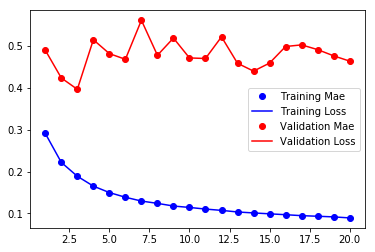

In [33]:
plot(history.history)